In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from PIL import Image
import random

In [ ]:
# Colab Drive Path
train_dir = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/train"
val_dir   = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/val"
test_dir  = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/test"

# Local Path
# train_dir = "Dataset/train"
# val_dir   = "Dataset/val"
# test_dir =  "Dataset/test"

In [ ]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64,
    seed=111,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64,
    seed=111,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64,
    seed=111,
    shuffle=False
)

Found 14000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.


#**Exploratory Data Analysis (EDA) Report**

In this section, we will analyze the dataset to better understand its structure, balance, and quality before training the model.  
The goal is to ensure that the dataset is clean, balanced, and suitable for training.

We will cover:
1. Dataset structure (number of classes, images, and splits) & Class distribution..  
2. Image properties (shape, channels, pixel intensity).
3. Key observations.


In [ ]:
# Step 1: Dataset Structure & Class Distribution

# Class names
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Number of Classes: {num_classes}")

Classes: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
Number of Classes: 10


In [ ]:
# Count number of images in each split
train_count = tf.data.experimental.cardinality(train_ds).numpy() * 64  # batch_size=64
val_count   = tf.data.experimental.cardinality(val_ds).numpy() * 64
test_count  = tf.data.experimental.cardinality(test_ds).numpy() * 64

print(f"Training images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")
print(f"Total images: {train_count + val_count + test_count}")

Training images: 14016
Validation images: 3008
Test images: 3008
Total images: 20032


In [ ]:
def get_class_counts_from_dir(base_dir):
    class_counts = {}
    for class_name in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [ ]:
# Get counts for each split
train_counts = get_class_counts_from_dir(train_dir)
val_counts   = get_class_counts_from_dir(val_dir)
test_counts  = get_class_counts_from_dir(test_dir)

df_counts = pd.DataFrame({
    "Train": train_counts,
    "Validation": val_counts,
    "Test": test_counts
}).T

In [ ]:
pd.set_option("display.max_columns", None)  # show all columns in one row
pd.set_option("display.width", 150)         # increase console width

print("Dataset Class Distribution:\n")
print(df_counts)

Dataset Class Distribution:

            01_palm  02_l  03_fist  04_fist_moved  05_thumb  06_index  07_ok  08_palm_moved  09_c  10_down
Train          1400  1400     1400           1400      1400      1400   1400           1400  1400     1400
Validation      300   300      300            300       300       300    300            300   300      300
Test            300   300      300            300       300       300    300            300   300      300


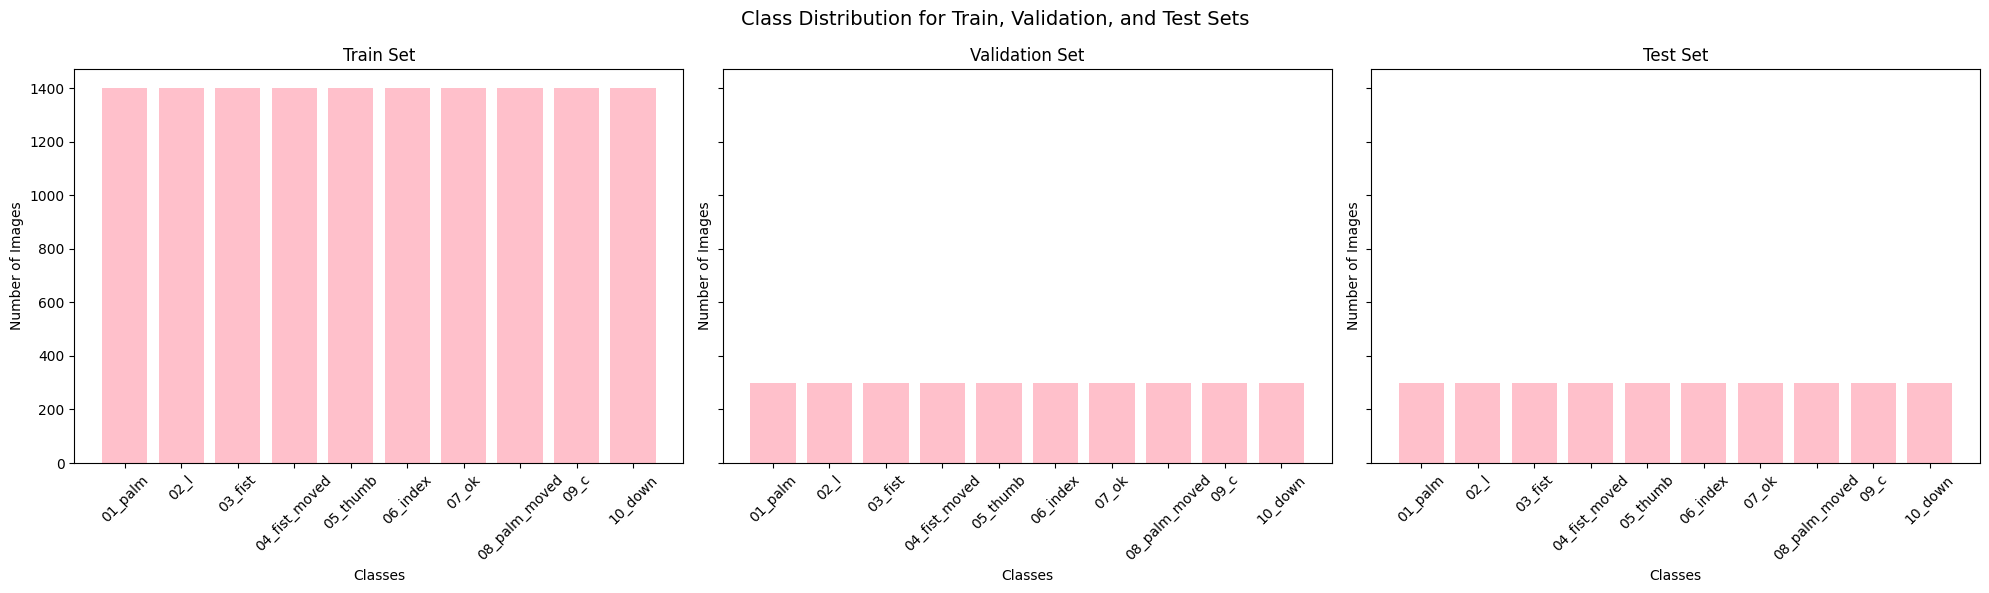

In [ ]:
# Class Distribution
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

datasets = [("Train Set", train_counts),
            ("Validation Set", val_counts),
            ("Test Set", test_counts)]

for ax, (title, counts) in zip(axes, datasets):
    ax.bar(counts.keys(), counts.values(), color="pink")
    ax.set_title(title)
    ax.set_xlabel("Classes")
    ax.set_ylabel("Number of Images")
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Class Distribution for Train, Validation, and Test Sets", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# step 2: Image properties

# Shape of Images and labels in one batch
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)   # (batch_size, height, width, channels)
    print("Labels batch shape:", labels.shape)

    # Check one image
    img = images[0].numpy()
    print("Image shape:", img.shape)
    print("Image dtype:", img.dtype)

    # Check Dtype & Value Range Across the whole batch
    batch_min = images.numpy().min()
    batch_max = images.numpy().max()
    batch_mean = images.numpy().mean()
    batch_std = images.numpy().std()

    print("Min pixel value in batch:", batch_min)
    print("Max pixel value in batch:", batch_max)
    print("Mean pixel value in batch:", batch_mean)
    print("Std pixel value in batch:", batch_std)


Images batch shape: (64, 224, 224, 3)
Labels batch shape: (64,)
Image shape: (224, 224, 3)
Image dtype: float32
Min pixel value in batch: 0.75514746
Max pixel value in batch: 254.10968
Mean pixel value in batch: 26.721296
Std pixel value in batch: 55.81238


In [ ]:
def plot_pixel_histogram(dataset, bins=50, num_batches=1):
    """
    Plots histogram of pixel intensities from a given tf.data.Dataset (one or more batches).

    Parameters:
        dataset: batched dataset.
        bins: Number of histogram bins.
        num_batches: Number of batches to sample from (default=1).
    """
    pixel_values = []

    for i, (images, labels) in enumerate(dataset.take(num_batches)):
        # Convert batch to numpy
        batch_array = images.numpy().flatten()
        pixel_values.extend(batch_array)

    pixel_values = np.array(pixel_values)

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(pixel_values, bins=bins, color="green", edgecolor="black", alpha=0.8)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # stats
    print(f"\nAnalyzed {num_batches} batch")
    print(f"Total pixels analyzed: {len(pixel_values):,}")
    print(f"Min: {pixel_values.min():.2f}, Max: {pixel_values.max():.2f}, Mean: {pixel_values.mean():.2f}, Std: {pixel_values.std():.2f}")


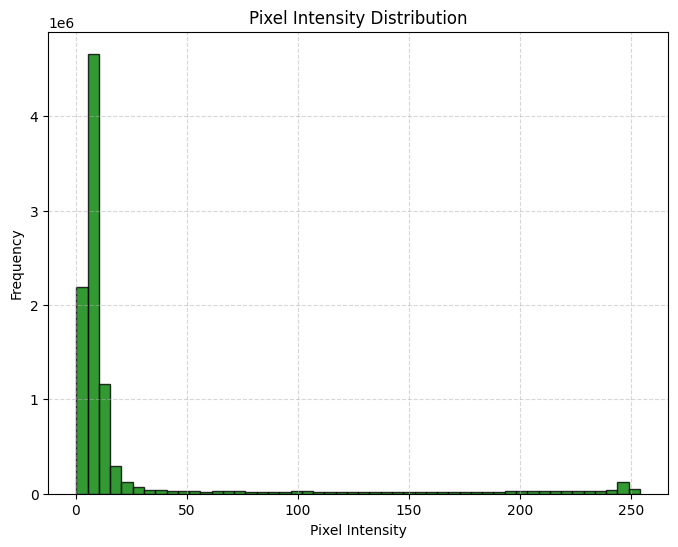


Analyzed 1 batch
Total pixels analyzed: 9,633,792
Min: 0.31, Max: 254.11, Mean: 24.88, Std: 52.86


In [ ]:
# Histogram of train_ds
plot_pixel_histogram(train_ds, bins=50, num_batches=1)

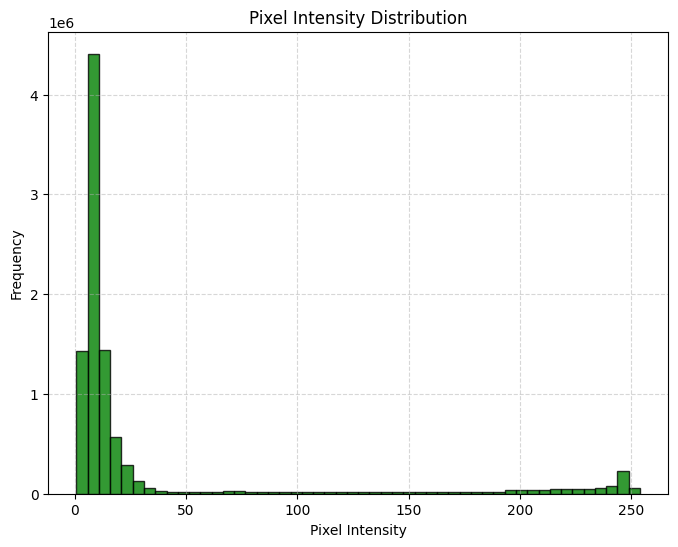


Analyzed 1 batch
Total pixels analyzed: 9,633,792
Min: 0.78, Max: 253.96, Mean: 33.47, Std: 64.22


In [ ]:
# Histogram of test_ds
plot_pixel_histogram(test_ds, bins=50, num_batches=1)

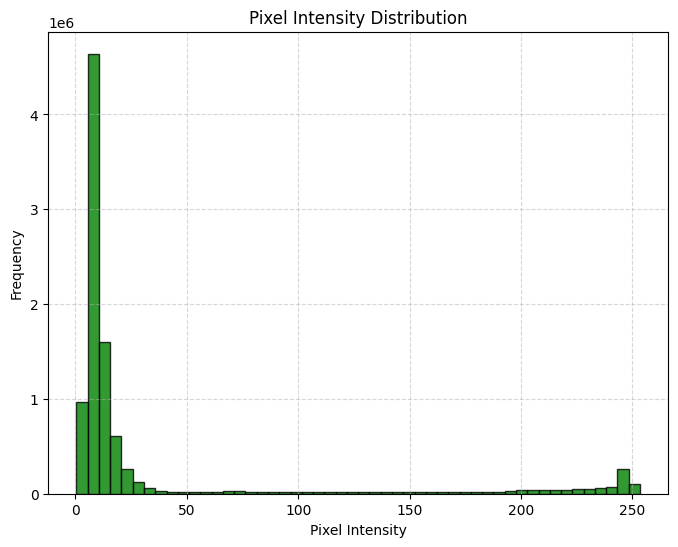


Analyzed 1 batch
Total pixels analyzed: 9,633,792
Min: 0.38, Max: 253.49, Mean: 34.67, Std: 66.02


In [ ]:
# Histogram of test_ds
plot_pixel_histogram(val_ds, bins=50, num_batches=1)

#**Image Preprocessing & Augmentation**

**Segmentation**  
We experimented with background subtraction / color-based segmentation to isolate the hand from the background. However, the images in our dataset already have clean backgrounds with minimal noise. Therefore, the segmented images looked very similar to the originals, and segmentation did not add significant benefit for training.

---

**Normalization**  
We applied normalization to scale pixel values from the range [0, 255] down to [0, 1]. This ensures more stable training and faster convergence.

---

**Data Augmentation**  
We applied data augmentation To increase dataset variability and reduce overfitting by creating modified versions of training images so the model can generalize better to unseen data.  

We used the following transformations:  
- **Random Flip (horizontal):** Helps the model learn that left/right orientations of the hand are equally valid.  
- **Random Rotation (0.1):** Introduces slight rotations to simulate natural variation in how hands appear.  
- **Random Zoom (0.1):** Covers different hand sizes or distances from the camera.  
- **Random Translation (0.1, 0.1):** Allows the model to handle shifts in hand position.  
- **Random Contrast (0.1):** Teaches the model to be able to handle different lighting conditions.

In [ ]:
def segment_hand(image):
    """
    Apply grayscale threshold segmentation (Otsu’s method).
    """
    # Convert TensorFlow tensor → NumPy array
    if not isinstance(image, np.ndarray):
        image = image.numpy()

    # Scale to [0,255] and convert to uint8
    if image.max() <= 1.0:
        img = (image * 255).astype("uint8")
    else:
        img = image.astype("uint8")

    # Ensure the image is grayscale
    if img.ndim == 3 and img.shape[-1] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # Otsu’s threshold
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply mask to the images
    segmented = cv2.bitwise_and(img, img, mask=mask)

    return segmented

In [ ]:
# def tf_segment_hand(x):
#     seg = tf.py_function(func=segment_hand, inp=[x], Tout=tf.uint8)
#     seg.set_shape([224, 224, 3])   # Set image shape
#     return seg

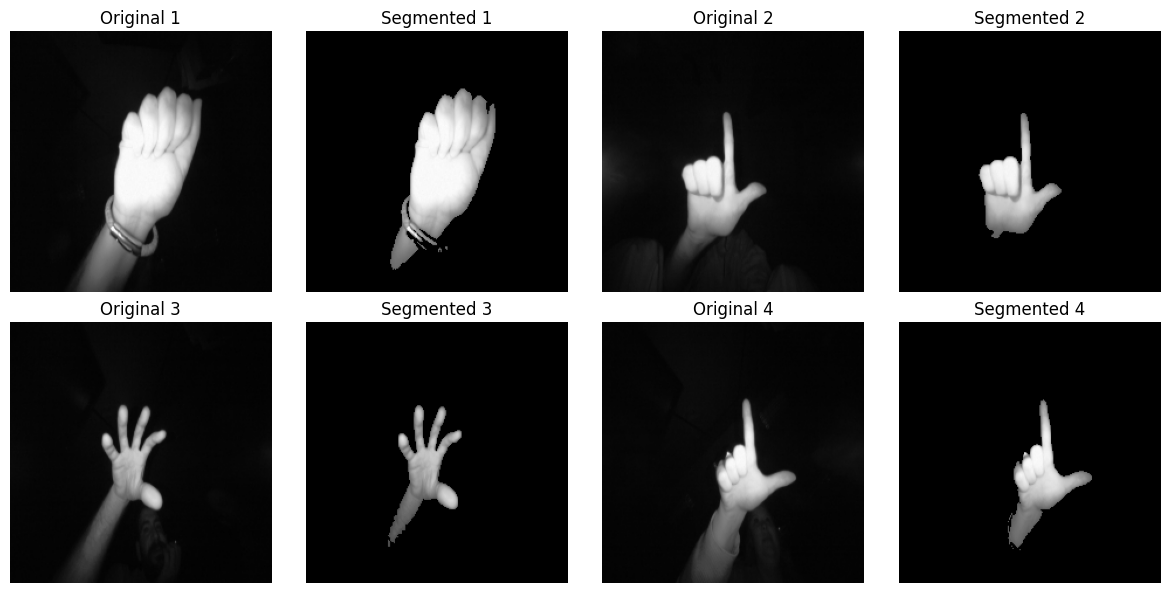

In [ ]:
# Take one batch from training set
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))

    for i in range(4):  # Take the first 4 images
        sample_img = images[i]
        segmented_img = segment_hand(sample_img)

        # Row/col position:
        row = i // 2   # 0 or 1
        col = i % 2    # 0 or 1

        # Original
        plt.subplot(2, 4, row*4 + col*2 + 1)
        plt.imshow(sample_img.numpy().astype("uint8"), cmap="gray")
        plt.title(f"Original {i+1}")
        plt.axis("off")

        # Segmented
        plt.subplot(2, 4, row*4 + col*2 + 2)
        plt.imshow(segmented_img, cmap="gray")
        plt.title(f"Segmented {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Define the Normalization Layer
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

In [ ]:
# train_data = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(tf_segment_hand(x), training=True)), y))
# val_data   = val_ds.map(lambda x, y: (normalization_layer(tf_segment_hand(x)), y))
# test_data  = test_ds.map(lambda x, y: (normalization_layer(tf_segment_hand(x)), y))

In [ ]:
# Apply preprocessing to The Images
train_data = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))
val_data   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_data  = test_ds.map(lambda x, y: (normalization_layer(x), y))